# Fig: bifurcation diagrams of DMFD & $K_2$ vs $\kappa / N$
ISHII Hidemasa

In [1]:
using Roots, Polynomials, CairoMakie
import ColorSchemes as cs

In [2]:
### new format for axes tick labels on log10 scale ###
digits_super = collect("⁰¹²³⁴⁵⁶⁷⁸⁹")
digits_sub = collect("₀₁₂₃₄₅₆₇₈₉")

function superscript(n::Integer; dsup=digits_super, dsub=digits_sub)
    if_pos = n >= 0
    if if_pos
        return join(dsup[begin .+ reverse(digits(n))])
    else
        return "⁻" * join(dsup[begin .+ reverse(digits(-n))])
    end
end

function log10format(value; digits=2, minabsexp=3)
    exponent = floor(Integer, log10(value))

    if abs(exponent) < minabsexp
        # no formatting for small value
        return "$(round(value, digits=max(1 - exponent, 1)))" 
    end

    coeff = round(value / 10.0^exponent, RoundNearestTiesUp; digits=digits)
    if coeff == 1
        return "10$(superscript(exponent))"
    else
        return "$(coeff)×10$(superscript(exponent))"
    end
end

log10format (generic function with 1 method)

In [3]:
# fixed parameter values
r = 0.05
D = 0.005

0.005

$$\begin{aligned}
  f_\Theta(\Theta) =& -\Theta^3 + (1 + r) \Theta^2 - (r + 3 Z^*) \Theta + (1 + r) Z^* \\
  Z^* :=& \frac{D}{K} \left( 1 - \frac{\kappa}{N} \right)
\end{aligned}$$
$$ f_\Theta'(\Theta) = -3 \Theta^2 + 2 (1 + r) \Theta - r - 3 Z^* $$
$$ f_\Theta'(\Theta^*) = 0 \Longleftarrow \Theta^* = \frac{1 + r - \sqrt{1 - r + r^2 - 9 Z^*}}{3} $$

By solving $f_\Theta(\Theta^*) = 0$ for $K$ at each value of $\kappa / N$, one numerically obtains $K_2(\kappa / N)$.

In [4]:
# assumption: K - f'(Θ) ≈ K
Zstar(κ_N, K, D=D) = D / K * (1 - κ_N);
dfdΘ(Θ, κ_N, K, r=r) = -3 * Θ^2 + 2 * (1 + r) * Θ - r - 3 * Zstar(κ_N, K);
f_Θ(Θ, κ_N, K, r=r, D=D) = (
    -Θ^3 + (1 + r) * Θ^2 - (r + 3 * Zstar(κ_N, K)) * Θ + (1 + r) * Zstar(κ_N, K)
);

fΘ_pol(K, κ_N; r=r, D=D) = Polynomial([
    (1 + r) * Zstar(κ_N, K, D), 
    -(r + 3 * Zstar(κ_N, K, D)),
    1 + r,
    -1
], :Θ)

Θstar(κ_N, K, r=r) = (1 + r - sqrt(1 - r + r^2 - 9 * Zstar(κ_N, K))) / 3

Θstar (generic function with 2 methods)

In [5]:
f0(κ_N, K) = f_Θ(Θstar(κ_N, K), κ_N, K)

function calc_K2(κ_N)
    f0_tmp(K) = f0(κ_N, K)
    return find_zero(f0_tmp, (1.0, 8.5))
end

calc_K2 (generic function with 1 method)

In [6]:
function draw_bd!(gl::GridLayout, κ_N; title="", 
    K_vec=[
        collect(logrange(1, 4.9, 11)); 
        collect(logrange(5, 9.9, 201));
        collect(logrange(10, 100, 21))
    ]
)
    #########
    # # collect K and X* for two stable and one unstable branches
    
    # find roots
    real_roots = Vector{Vector{Float64}}(undef, length(K_vec))
    for (j, K) in enumerate(K_vec)
        real_roots[j] = filter(isreal, roots(fΘ_pol(K, κ_N)))
    end

    # upper stable branch
    K_us = Vector{Float64}()  
    fp_us = Vector{Float64}()

    # lower stable branch
    K_ls = Vector{Float64}()  
    fp_ls = Vector{Float64}()

    # unstable branch
    K_un = Vector{Float64}()  
    fp_un = Vector{Float64}()

    # collect K and X*
    for (K, roots) in zip(K_vec, real_roots)
        if length(roots) == 1
            push!(K_us, K)
            push!(fp_us, only(roots))
        elseif length(roots) == 3
            sortedroots = sort(roots)
            push!(K_ls, K)
            push!(fp_ls, sortedroots[1])
            push!(K_un, K)
            push!(fp_un, sortedroots[2])
            push!(K_us, K)
            push!(fp_us, sortedroots[3])
        else
            @warn "unexpected number of roots" len_roots = length(roots)
        end
    end

    ##########
    # # visualization

    # prepare Axes and Labels
    Label(gl[1:2, 1], "fixed points of DMFD", rotation=π/2)
    axopts = (
        xautolimitmargin=(0, 0), xscale=log10, xgridvisible=false, 
        ygridvisible=false, yticks=-1:0.05:2, yminorticksvisible=true, yminorticks=IntervalsBetween(5),
    )
    ax1 = Axis(gl[1, 2]; xticksvisible=false, xticklabelsvisible=false, axopts...)
    ax2 = Axis(gl[2, 2]; 
        xlabel="K", xtickformat=values -> log10format.(values, digits=2),
        xticks=(10.0).^(-5:5), xminorticksvisible=true, 
        xminorticks=IntervalsBetween(10),
        axopts...
    )
    linkxaxes!(ax1, ax2)
    # add title if it is given
    if length(title) > 0
        Label(gl[begin-1, 1:2], title; fontsize=20, tellwidth=false)
    end

    # set y limit
    ylims!(ax2, -0.01, 0.06)
    ylims!(ax1, 0.94, 1.01)

    # annotate X=0, r, and 1
    hlines!(ax2, r, color=(:black, 1.0), linestyle=:dash, linewidth=1)
    hlines!(ax2, 0, color=(:black, 1.0), linewidth=1)
    hlines!(ax1, 1, color=(:black, 1.0), linewidth=1)
    # annotate K2
    K2 = calc_K2(κ_N)
    for ax in (ax1, ax2)
        vlines!(ax, K2, color=:black, linestyle=:dash)
    end
    text!(ax2, K2, 0; text=rich("K", subscript("2"), "≈$(round(K2, digits=2))"),
        align=(:right, :bottom), offset=(-2, 4),
    )
    # line plot of branches
    lineopts = (linewidth=3.0, color=(:purple3, 0.8))
    lines!(ax1, K_us, fp_us; linestyle=:solid, lineopts...)
    lines!(ax2, K_ls, fp_ls; linestyle=:solid, lineopts...)
    lines!(ax2, K_un, fp_un; linestyle=(:dot, :dense), lineopts...)
     
    # adjust margins
    rowgap!(gl, 8)
    colgap!(gl, 5)   
    
    return nothing
end

draw_bd! (generic function with 1 method)

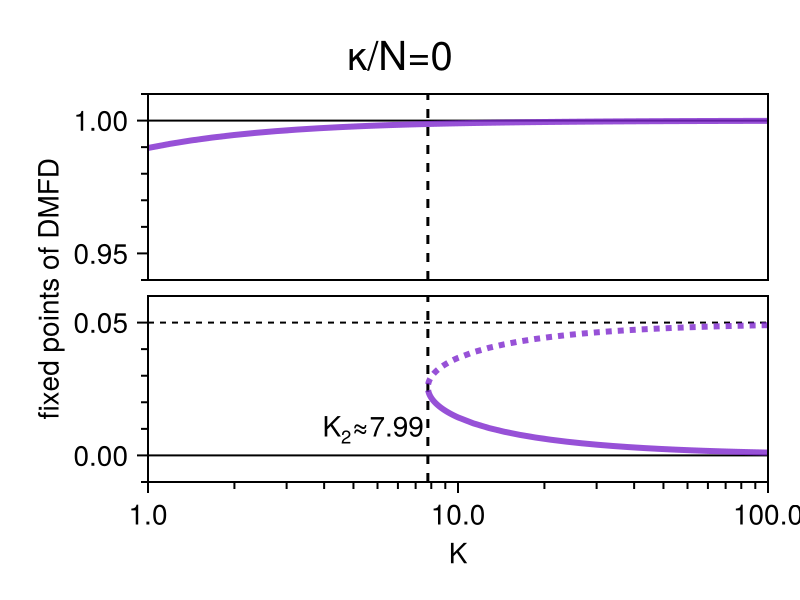

In [7]:
# draw bifurcation diagram for the fully-connected large network case
let 
    fig = Figure(size=(400, 300))
    axopts = (xscale=log10, xautolimitmargin=(0, 0), xtickformat=vals -> log10format.(vals, digits=2))

    gl = fig[1, 1] = GridLayout()
    draw_bd!(gl, 0; title="κ/N=0")
    display(fig)
end;

In [8]:
# calculate K2 as a function of κ/N 
vec_κ_N = (10.0).^(-3:0.05:-0.7)
vec_K2 = Vector{Float64}(undef, length(vec_κ_N))

for (j, κ_N) in enumerate(vec_κ_N)
    vec_K2[j] = calc_K2(κ_N)
end

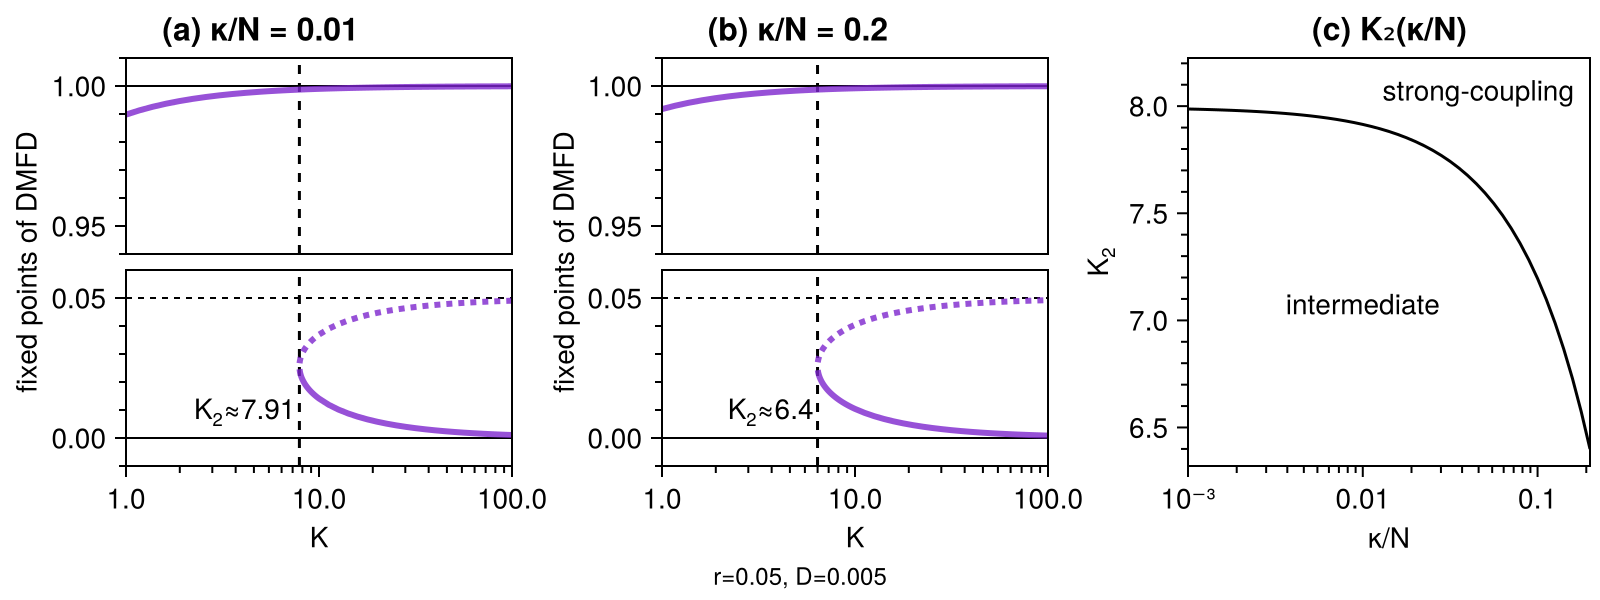

In [9]:
# produce the figure
let ifsave=true
    κ_N_vec = [0.01, 0.2]
    # generate Figure
    fig = Figure(size=(800, 300), figure_padding=(5, 5, 5, 5))
    t_labs = ("a", "b", "c")
    # add GridLayouts for bifurcation diagrams
    gl1 = fig[1, 1] = GridLayout()
    gl2 = fig[1, 2] = GridLayout()
    # add Axes for K2(κ/N)
    ax3 = Axis(fig[1, 3]; 
        xscale=log10, xtickformat=vals -> log10format.(vals, digits=2),
        xlabel="κ/N", xautolimitmargin=(0, 0), xgridvisible=false,
        xticks=(10.0).^(-5:5), xminorticksvisible=true,
        xminorticks=IntervalsBetween(10),
        ylabel=rich("K", subscript("2")), ygridvisible=false,
        yticks=5:0.5:10, yminorticks=IntervalsBetween(5),
        yminorticksvisible=true, yautolimitmargin=(0.05, 0.15),
    )
    # put panel labels
    lblopts = (fontsize=16, font=:bold, tellwidth=false)
    Label(fig[0, 1], "(a) κ/N = $(κ_N_vec[1])"; lblopts...)
    Label(fig[0, 2], "(b) κ/N = $(κ_N_vec[2])"; lblopts...)
    Label(fig[0, 3], "(c) K₂(κ/N)"; lblopts...)
    # plot bifurcation diagrams
    for (gl, κ_N) in zip((gl1, gl2), κ_N_vec)
        draw_bd!(gl, κ_N)
    end
    # plot K2 against κ/N
    lines!(ax3, vec_κ_N, vec_K2, color=:black)
    text!(ax3, 0.01, 7; text="intermediate", align=(:center, :bottom))
    text!(ax3, 1, 1; text="strong-coupling", 
        space=:relative, align=(:right, :top), offset=(-8, -8)
    )
    # annotate parameter values
    Label(fig[end+1, :], "r=$r, D=$D", tellwidth=false, fontsize=12)
    # adjust layouts
    colsize!(fig.layout, 3, Auto(0.8))
    rowgap!(fig.layout, 5)
    # save (if needed) and display the figure
    if ifsave save("output/fig-bd-and-K2.pdf", fig) end
    display(fig)
end;